In [11]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count()/2)

In [12]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './data',
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)

        # Upsample (transpose conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        return self.conv(x)

In [15]:
from typing import Optional


from torch.nn.modules.module import Module


class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()

        # python argparse를 지원하는 pytorch_lightning의 기능
        # argparse를 사용하면, 터미널에서 파라미터를 지정할 수 있다.
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discrminator = Discriminator()

        # random noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        # optimzers
        opt_g, opt_d = self.optimizers()

        real_imgs, _ = batch

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        ##########################
        # Optimize Discriminator #
        ##########################

        # train discriminator: max log(D(x)) + log(1 - D(G(z)))    
        # how well can it label as real
        y_hat_real = self.discrminator(real_imgs)

        y_real = torch.ones(real_imgs.size(0), 1)
        y_real = y_real.type_as(real_imgs)

        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # how well can it label as fake
        y_hat_fake = self.discrminator(self(z).detach())

        y_fake = torch.zeros(real_imgs.size(0), 1)
        y_fake = y_fake.type_as(real_imgs)

        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        ######################
        # Optimize Generator #
        ######################      

        # train generator: max log(D(G(z)))
    
        fake_imgs = self(z)
        y_hat = self.discrminator(fake_imgs)

        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs)

        g_loss = self.adversarial_loss(y_hat, y)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        self.log_dict({
            'g_loss': g_loss,
            'd_loss': d_loss
        }, prog_bar=True)

    
    def configure_optimizers(self):
        lr = self.hparams.lr

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discrminator.parameters(), lr=lr)

        return opt_g, opt_d
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()

In [16]:
dm = MNISTDataModule()
model = GAN()

epoch  0


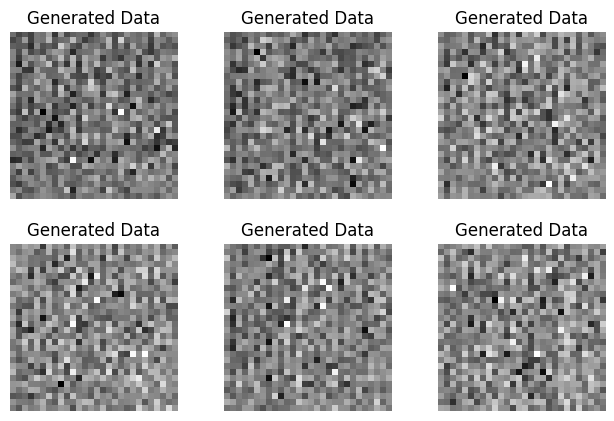

In [17]:
model.plot_imgs()

In [18]:
AVAIL_GPUS

1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | generator    | Generator     | 358 K 
1 | discrminator | Discriminator | 21.4 K
-----------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 430/430 [00:03<00:00, 116.20it/s, v_num=7, g_loss=2.260, d_loss=0.0989]epoch  0


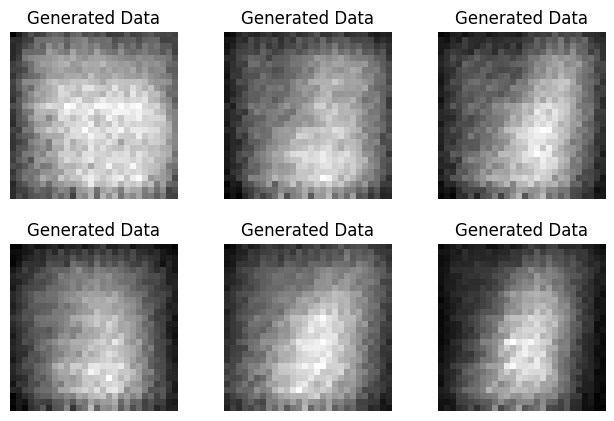

Epoch 1: 100%|██████████| 430/430 [00:03<00:00, 110.12it/s, v_num=7, g_loss=6.880, d_loss=0.0267] epoch  1


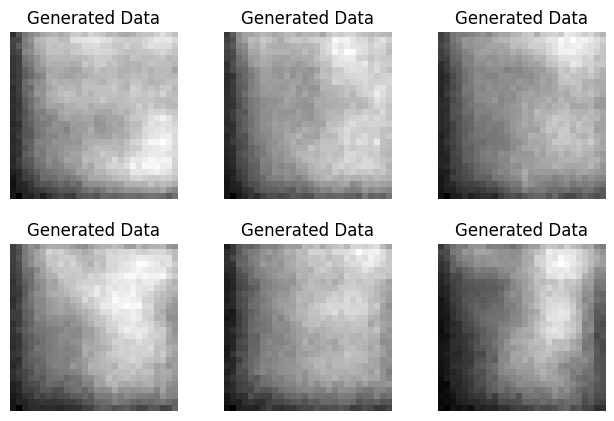

Epoch 2: 100%|██████████| 430/430 [00:03<00:00, 107.57it/s, v_num=7, g_loss=3.200, d_loss=0.0961]epoch  2


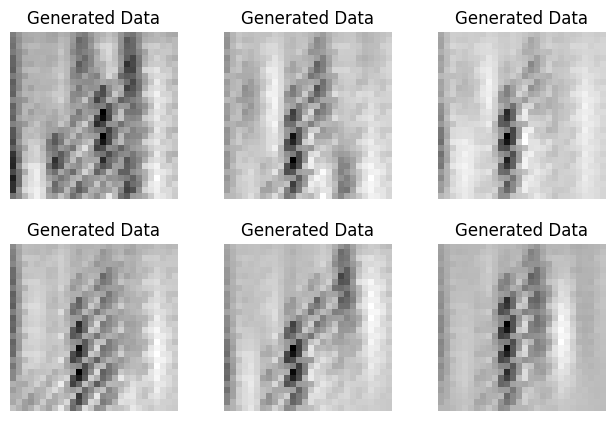

Epoch 3: 100%|██████████| 430/430 [00:03<00:00, 111.88it/s, v_num=7, g_loss=2.100, d_loss=0.264] epoch  3


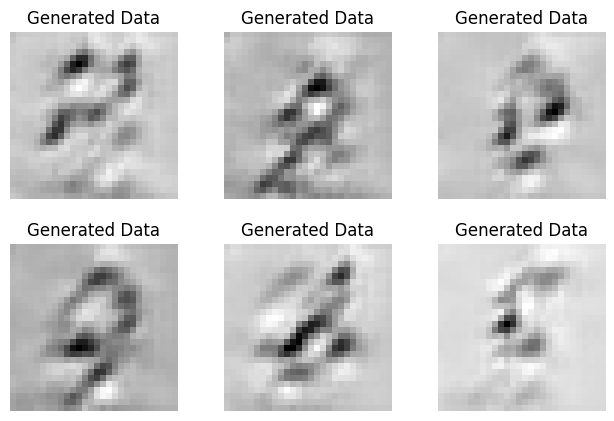

Epoch 4: 100%|██████████| 430/430 [00:03<00:00, 109.58it/s, v_num=7, g_loss=2.520, d_loss=0.209]epoch  4


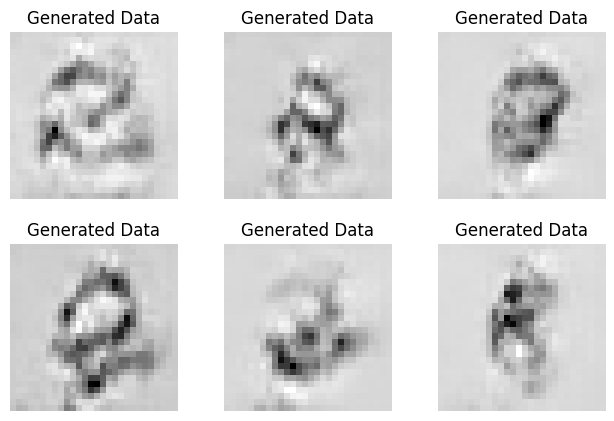

Epoch 5: 100%|██████████| 430/430 [00:03<00:00, 110.26it/s, v_num=7, g_loss=2.660, d_loss=0.193]epoch  5


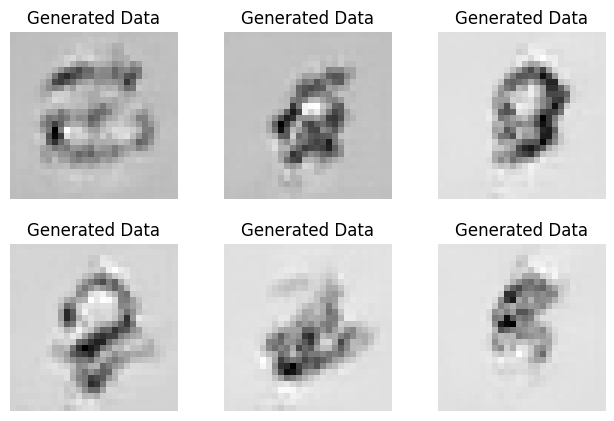

Epoch 6: 100%|██████████| 430/430 [00:03<00:00, 109.38it/s, v_num=7, g_loss=2.730, d_loss=0.167]epoch  6


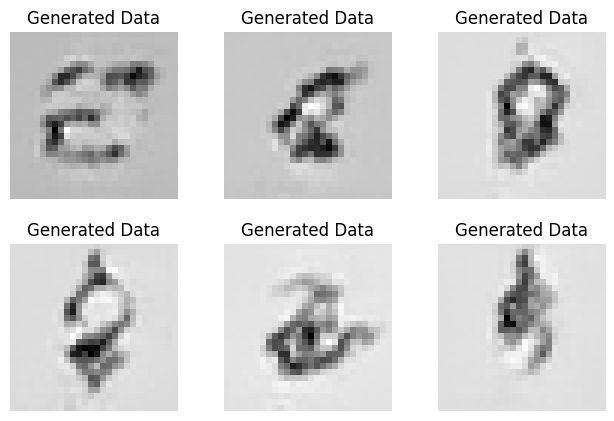

Epoch 7: 100%|██████████| 430/430 [00:04<00:00, 101.00it/s, v_num=7, g_loss=2.590, d_loss=0.167]epoch  7


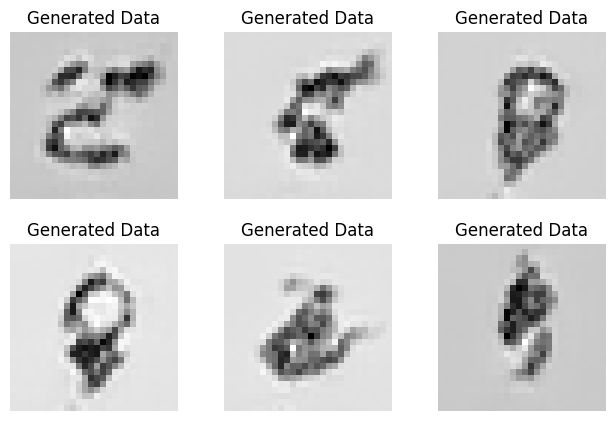

Epoch 8: 100%|██████████| 430/430 [00:03<00:00, 111.39it/s, v_num=7, g_loss=2.410, d_loss=0.228]epoch  8


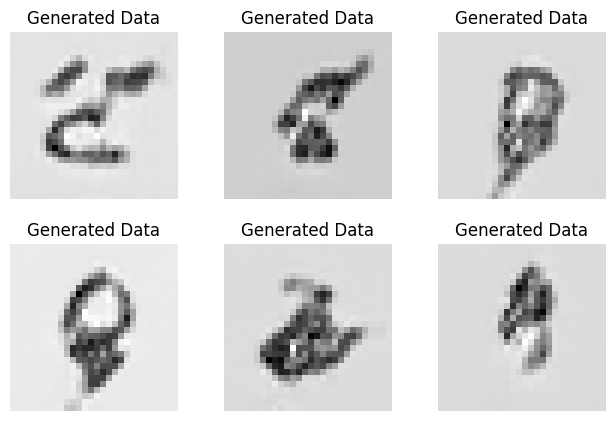

Epoch 9: 100%|██████████| 430/430 [00:03<00:00, 111.97it/s, v_num=7, g_loss=2.090, d_loss=0.284]epoch  9


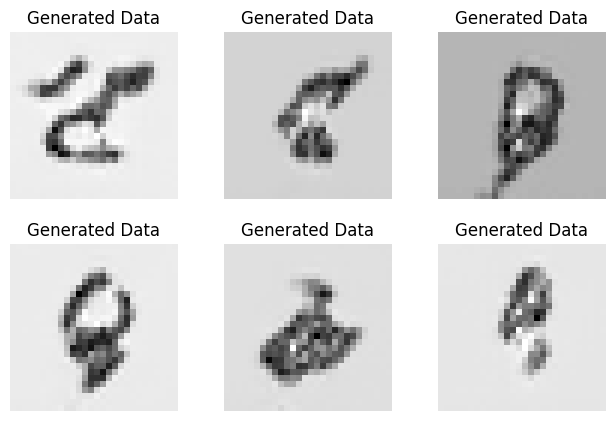

Epoch 10: 100%|██████████| 430/430 [00:03<00:00, 112.23it/s, v_num=7, g_loss=1.950, d_loss=0.338]epoch  10


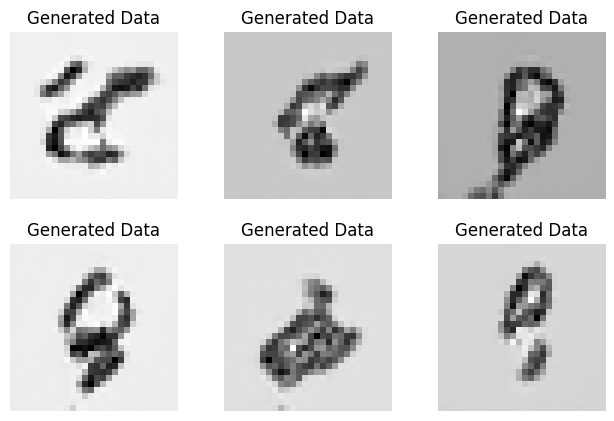

Epoch 11: 100%|██████████| 430/430 [00:03<00:00, 108.06it/s, v_num=7, g_loss=1.990, d_loss=0.318]epoch  11


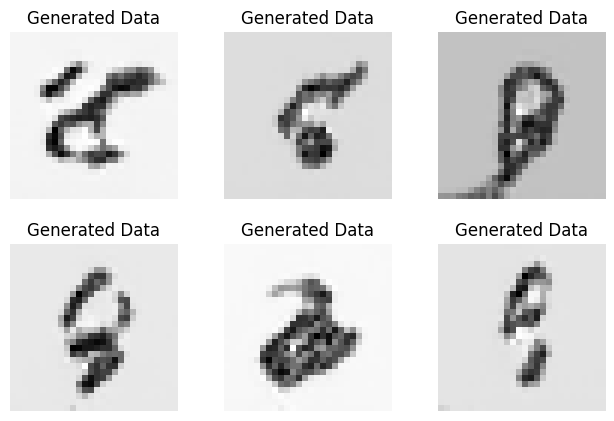

Epoch 12: 100%|██████████| 430/430 [00:03<00:00, 109.98it/s, v_num=7, g_loss=1.860, d_loss=0.304]epoch  12


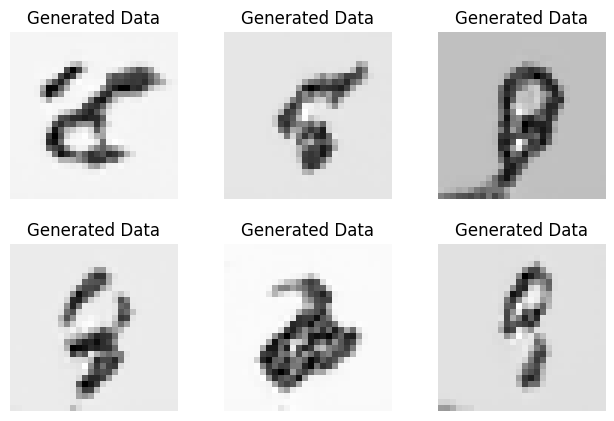

Epoch 13: 100%|██████████| 430/430 [00:03<00:00, 108.70it/s, v_num=7, g_loss=1.970, d_loss=0.316]epoch  13


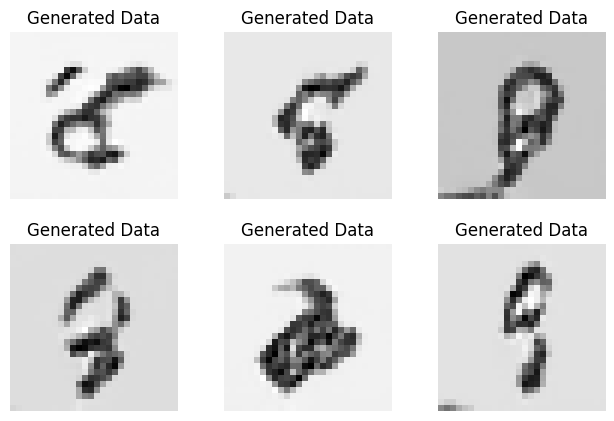

Epoch 14: 100%|██████████| 430/430 [00:03<00:00, 108.56it/s, v_num=7, g_loss=1.800, d_loss=0.305]epoch  14


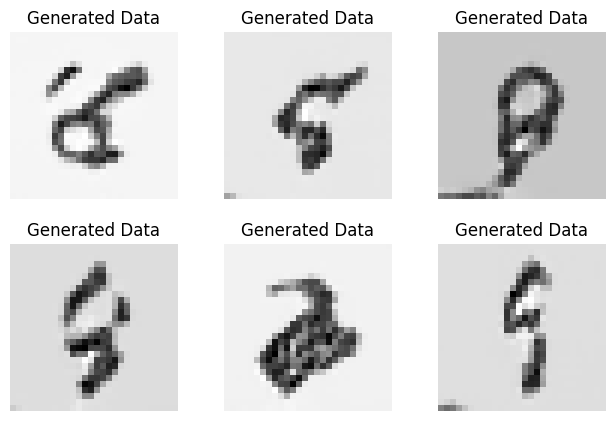

Epoch 15: 100%|██████████| 430/430 [00:03<00:00, 109.69it/s, v_num=7, g_loss=1.820, d_loss=0.364]epoch  15


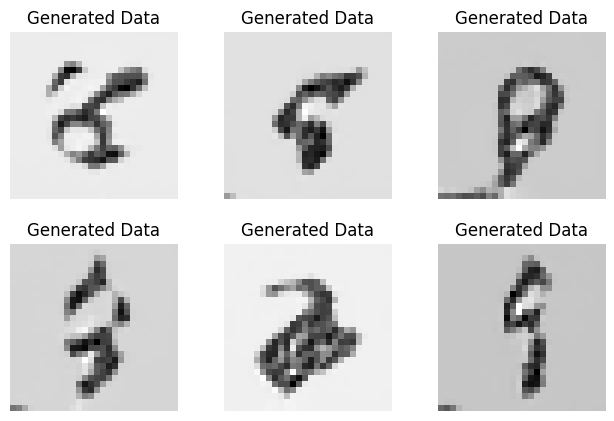

Epoch 16: 100%|██████████| 430/430 [00:03<00:00, 109.89it/s, v_num=7, g_loss=1.430, d_loss=0.446]epoch  16


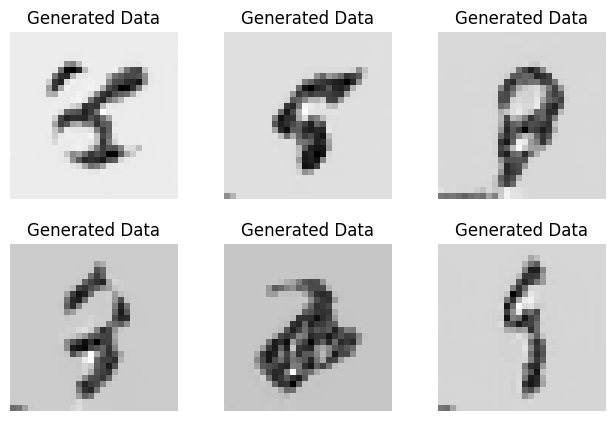

Epoch 17: 100%|██████████| 430/430 [00:03<00:00, 111.46it/s, v_num=7, g_loss=1.540, d_loss=0.404]epoch  17


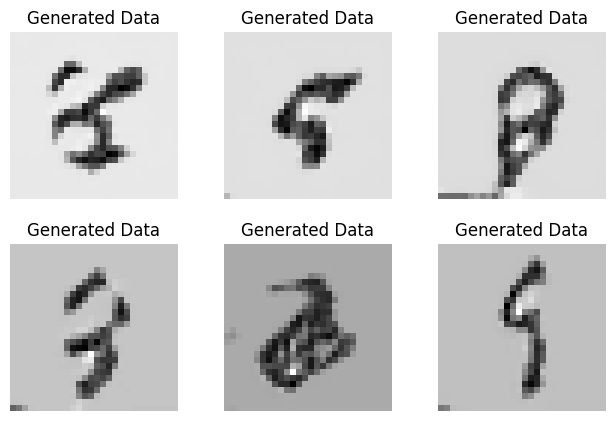

Epoch 18: 100%|██████████| 430/430 [00:03<00:00, 110.26it/s, v_num=7, g_loss=1.730, d_loss=0.550]epoch  18


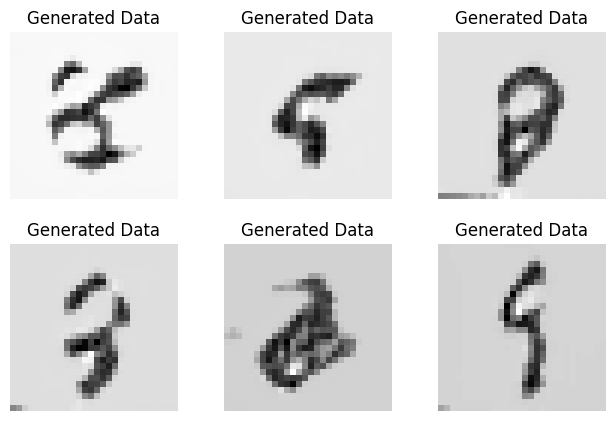

Epoch 19: 100%|██████████| 430/430 [00:03<00:00, 109.47it/s, v_num=7, g_loss=1.440, d_loss=0.414]epoch  19


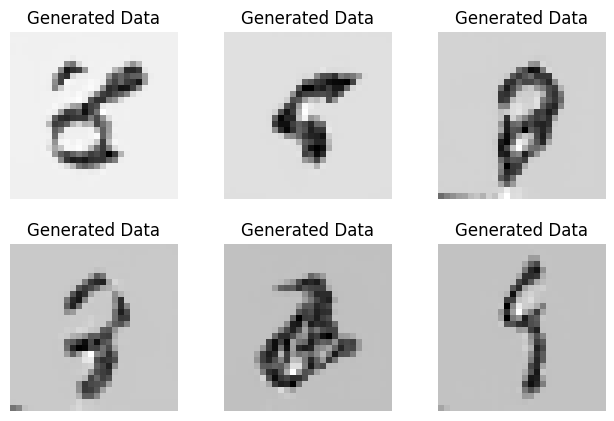

Epoch 20: 100%|██████████| 430/430 [00:03<00:00, 110.23it/s, v_num=7, g_loss=1.590, d_loss=0.476]epoch  20


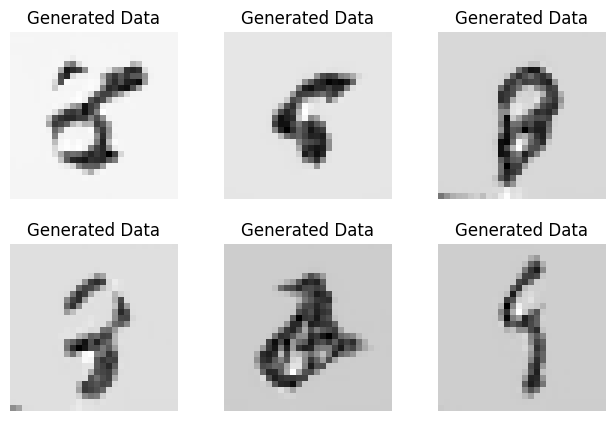

Epoch 21: 100%|██████████| 430/430 [00:03<00:00, 112.15it/s, v_num=7, g_loss=1.640, d_loss=0.428]epoch  21


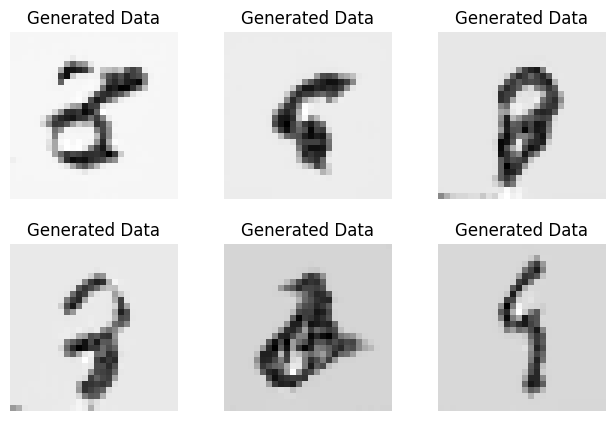

Epoch 22: 100%|██████████| 430/430 [00:03<00:00, 110.46it/s, v_num=7, g_loss=1.550, d_loss=0.465]epoch  22


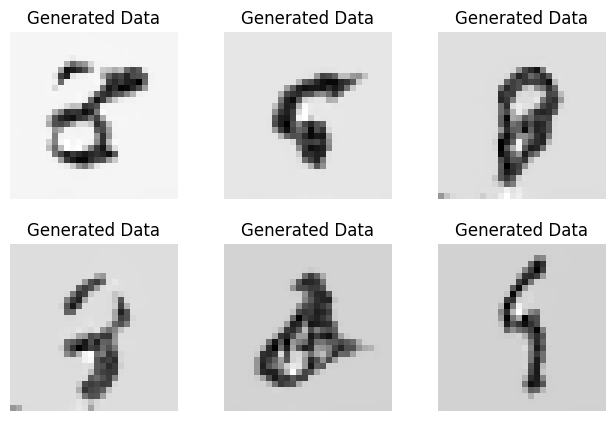

Epoch 23: 100%|██████████| 430/430 [00:03<00:00, 110.10it/s, v_num=7, g_loss=1.600, d_loss=0.461]epoch  23


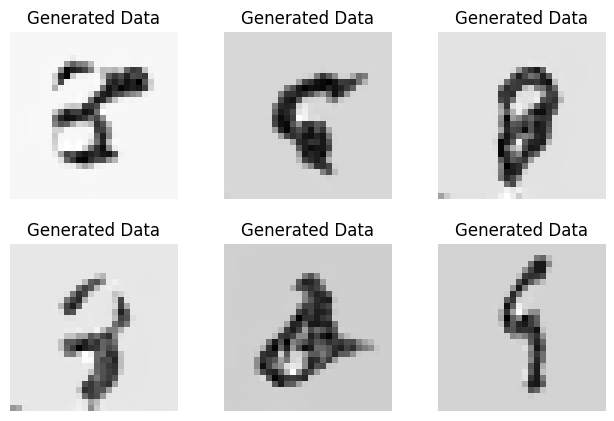

Epoch 24: 100%|██████████| 430/430 [00:03<00:00, 112.92it/s, v_num=7, g_loss=1.590, d_loss=0.455]epoch  24


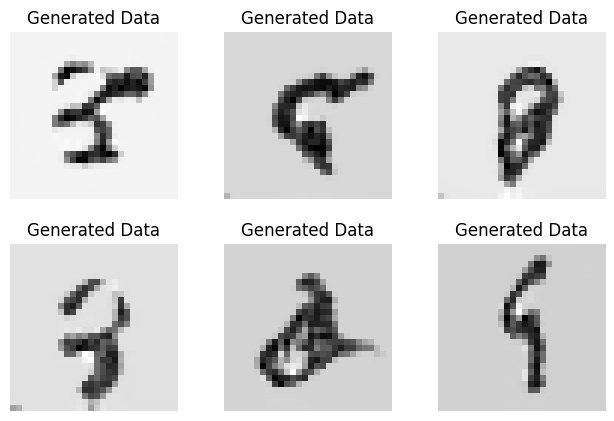

Epoch 25: 100%|██████████| 430/430 [00:03<00:00, 112.29it/s, v_num=7, g_loss=1.490, d_loss=0.474]epoch  25


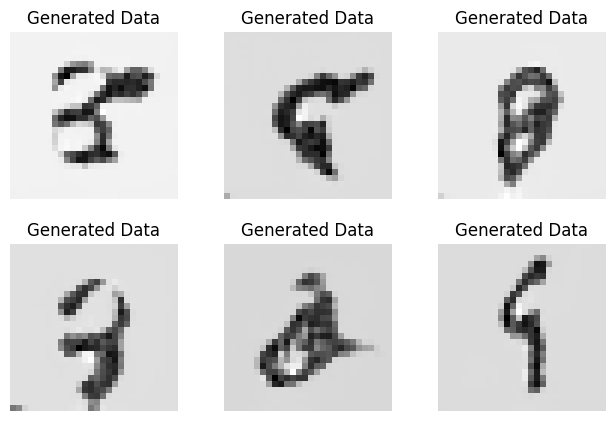

Epoch 26: 100%|██████████| 430/430 [00:03<00:00, 113.67it/s, v_num=7, g_loss=1.460, d_loss=0.538]epoch  26


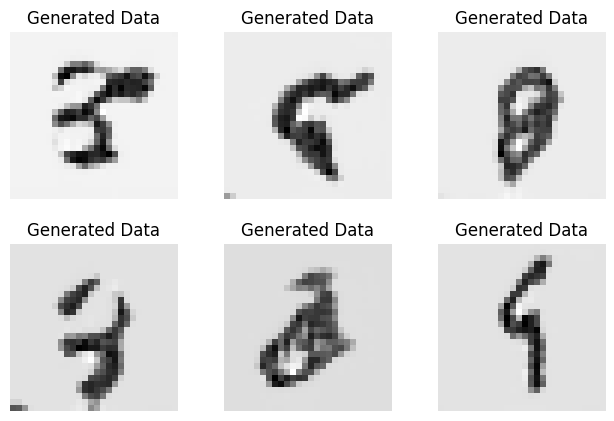

Epoch 27: 100%|██████████| 430/430 [00:03<00:00, 112.40it/s, v_num=7, g_loss=1.430, d_loss=0.481]epoch  27


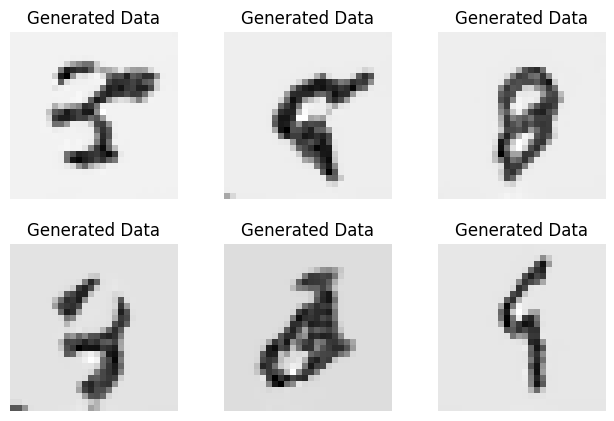

Epoch 28: 100%|██████████| 430/430 [00:03<00:00, 110.98it/s, v_num=7, g_loss=1.650, d_loss=0.414]epoch  28


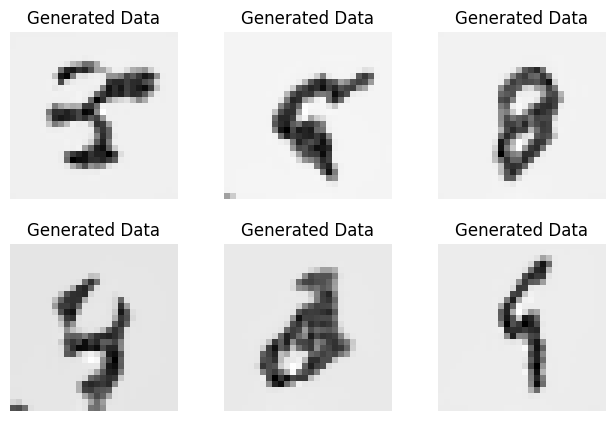

Epoch 29: 100%|██████████| 430/430 [00:03<00:00, 112.87it/s, v_num=7, g_loss=1.300, d_loss=0.481]epoch  29


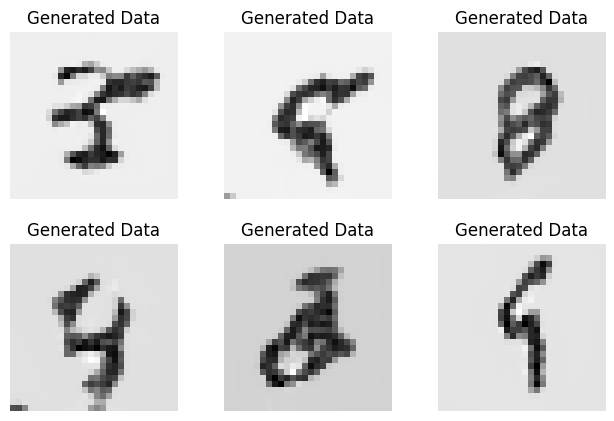

Epoch 30: 100%|██████████| 430/430 [00:03<00:00, 110.96it/s, v_num=7, g_loss=1.390, d_loss=0.526]epoch  30


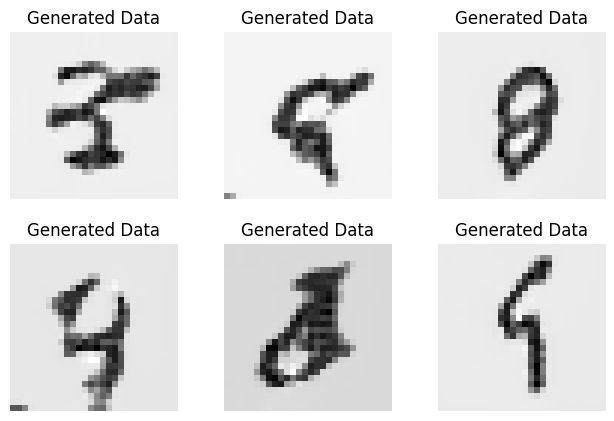

Epoch 31: 100%|██████████| 430/430 [00:03<00:00, 109.96it/s, v_num=7, g_loss=1.180, d_loss=0.516]epoch  31


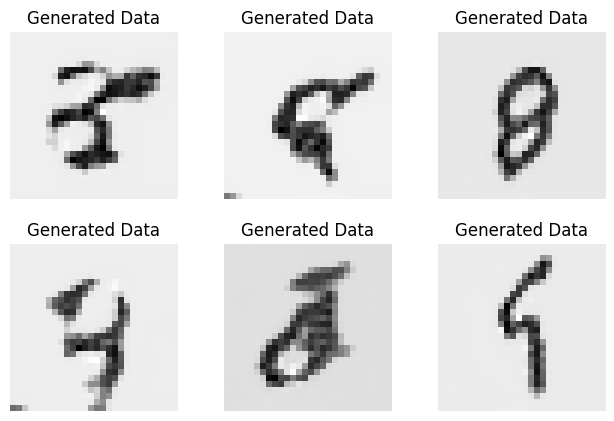

Epoch 32: 100%|██████████| 430/430 [00:03<00:00, 111.91it/s, v_num=7, g_loss=1.170, d_loss=0.469]epoch  32


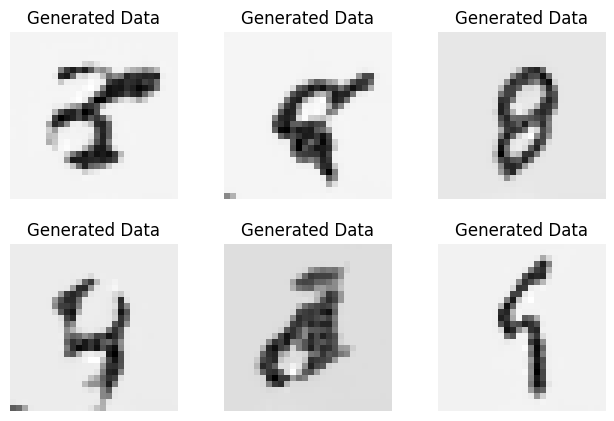

Epoch 33: 100%|██████████| 430/430 [00:03<00:00, 111.72it/s, v_num=7, g_loss=1.680, d_loss=0.528]epoch  33


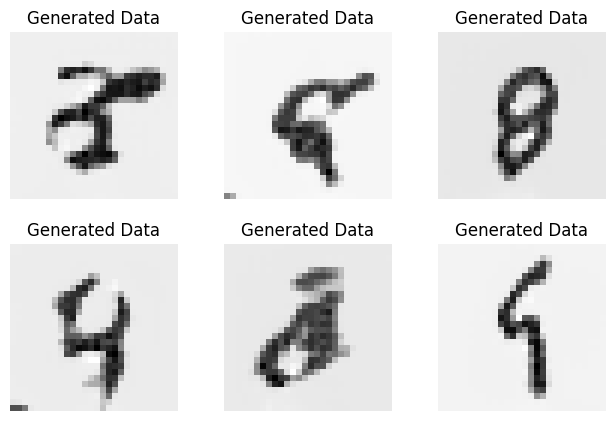

Epoch 34: 100%|██████████| 430/430 [00:03<00:00, 108.22it/s, v_num=7, g_loss=1.340, d_loss=0.506]epoch  34


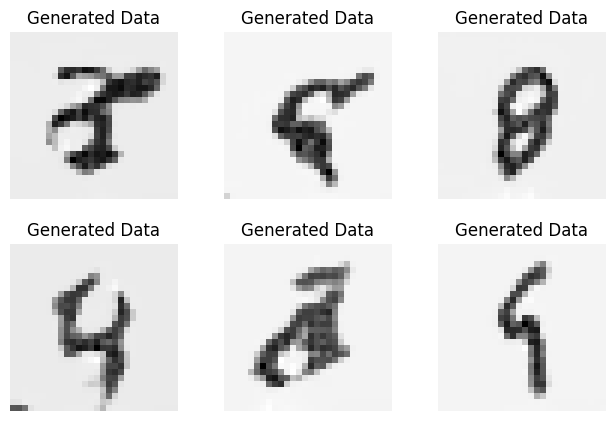

Epoch 35: 100%|██████████| 430/430 [00:03<00:00, 107.54it/s, v_num=7, g_loss=1.350, d_loss=0.456]epoch  35


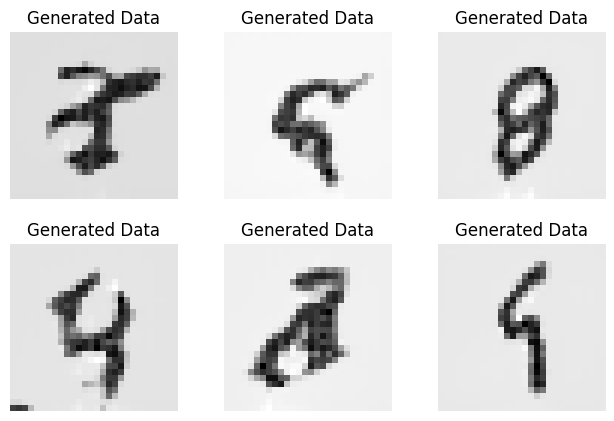

Epoch 36: 100%|██████████| 430/430 [00:03<00:00, 111.37it/s, v_num=7, g_loss=1.090, d_loss=0.516]epoch  36


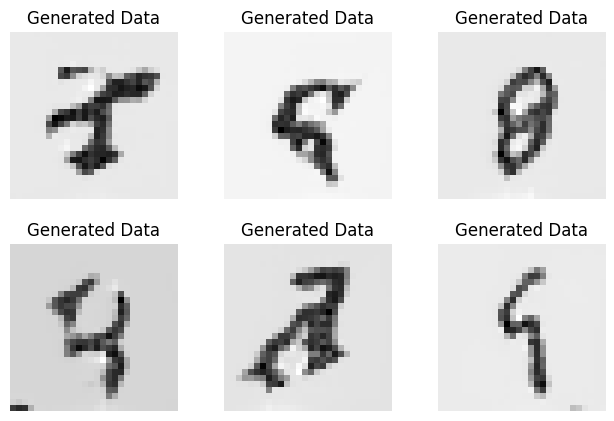

Epoch 37: 100%|██████████| 430/430 [00:03<00:00, 113.46it/s, v_num=7, g_loss=1.170, d_loss=0.575]epoch  37


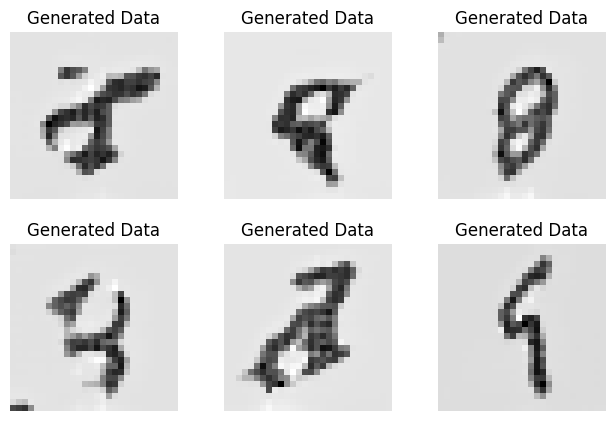

Epoch 38: 100%|██████████| 430/430 [00:03<00:00, 111.88it/s, v_num=7, g_loss=1.070, d_loss=0.529]epoch  38


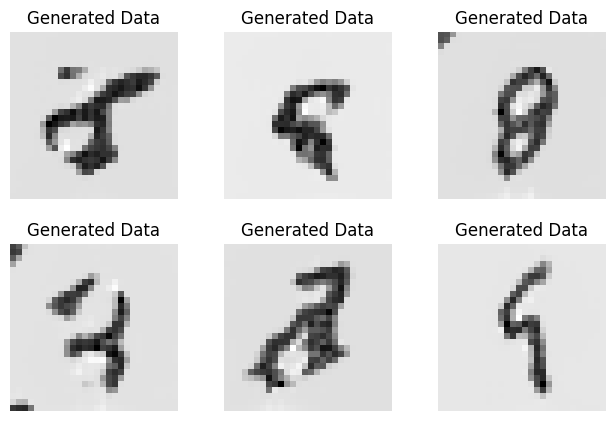

Epoch 39: 100%|██████████| 430/430 [00:03<00:00, 110.88it/s, v_num=7, g_loss=1.130, d_loss=0.492]epoch  39


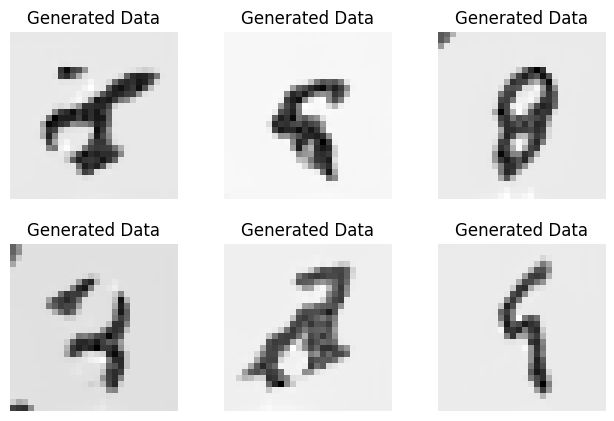

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 430/430 [00:04<00:00, 105.00it/s, v_num=7, g_loss=1.130, d_loss=0.492]


In [19]:
trainer = pl.Trainer(max_epochs=40, num_nodes=AVAIL_GPUS)
trainer.fit(model, dm)